## Imports, functions, scraping

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.tag import pos_tag
from sklearn.feature_extraction import text 

plt.style.use('fivethirtyeight')
sns.set(style='white')

In [2]:
# makes displaying large dateframes manageable
def display_all(df):
    '''temporarily increase display max and transposes the dateframe view
    for enhanced readability
    '''
    with pd.option_context("display.max_rows", 100, "display.max_columns", 100):
        display(df.head().transpose())

In [3]:
def get_wordnet_pos(word):
    """
    change POS tag to a tag which lemmatizer accepts
    """
    # pos_tag results is a list of tuples. [0][1][0] takes first upper-caseletter of the second element of the
    # first tuple
    tag = pos_tag(word_tokenize(word))[0][1][0].upper()
    tag_dict = {'J': wordnet.ADJ,
                'N': wordnet.NOUN,
                'V': wordnet.VERB,
                'R': wordnet.ADV}

    # return the dictionary value, noun if none
    return tag_dict.get(tag, wordnet.NOUN)

In [4]:
def cleanup(text):
    """ removes web links, words with digits, uses POS tags to lemmatize all parts of speech, makes everything lower-case,

    and removes punctuation"""

    # remove http:// url's
    text = re.sub(
        r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', text)

    # remove words containing digits
    text = re.sub(r'\w*\d\w*', '', text).strip()

    # lemmatize all part of speech, make them lower-case, remove punctuation
    text = ' '.join([lemmatizer.lemmatize(word, get_wordnet_pos(word)).lower() for word in word_tokenize(text) if
                    word.isalnum()])

    return text

In [5]:
def overlap(df1, df2, top_x=100):
    """ finds the overlap among top_x number columns of two dataframes.
    top_x is the number of columns, ranked by sum, highest to lowest
    """
    # sort columns according to their sum. take only the top_x columns with the highest sum
    # index returns the column names ( aka tokenized words in nlp). turn into set to find intersection easily.
    top1 = set(df1.sum().sort_values(ascending=False)[:top_x].index)
    top2 = set(df2.sum().sort_values(ascending=False)[:top_x].index)
    
    return (top1 & top2, round(len(top1 & top2)/top_x,2)) # return the set of common words, and portion 
    # of common words among top_x

In [6]:
def plt_bar(srs, name):
    """ simple function that prints barplot of a pandas series 
    with words and their counts in the corpus"""
    fig, ax = plt.subplots(figsize=(15,6))
    sns.barplot(x=srs.index,y=srs.values)
    ax.set_title(f'{name} (without stopwords)',
                 fontsize=21, color='darkorchid')
    ax.set_ylabel(srs.name, fontsize=18)
    ax.set_xlabel('Words \n*no stopwords',fontsize=18,
                  color='darkgoldenrod')

In [7]:
def update_stopwords(lst):
    """add extra stopwords to the sklearn's stopword list"""

    stopwords = text.ENGLISH_STOP_WORDS  # reset the stopwards,
    # so that we don't add duplicates
    stopwords = text.ENGLISH_STOP_WORDS.union(lst)  # merge the sklearn's
    # stopword list with the updated list of my stopwords

    # update the vectorizer
    cvec = CountVectorizer(stop_words=stopwords)
    return(stopwords)

In [8]:
def get_stopwords():
    return stopwords

In [9]:
lemmatizer = WordNetLemmatizer()

In [10]:
# ensure we always work with the same, big file with 6000 subreddit posts, which, for the duration
# of the project, won't change even if we re-run the scraping cell 
reddit2 = pd.read_csv('../datasets/ancients_for_NLP.csv')

## EDA

In [11]:
reddit2.head()

,created_utc,title,selftext,subreddit
0,1641904278,Minoan girl chilling,NaN,ancientgreece
1,1641859463,Book Reccs for World Civ I,I’m looking for a book to review in my World C...,ancientgreece
2,1641837949,I've started a supplementary twitch stream of ...,"Hi all, I'm a high school teacher and I've bee...",ancientgreece
3,1641832030,Dark Academia:A Level Ancient History- Athens ...,NaN,ancientgreece
4,1641819157,The Ancient Greek Hero course,If you're interested in delving deeper into th...,ancientgreece


In [12]:
reddit2.shape

(5992, 4)

In [13]:
reddit2.index

RangeIndex(start=0, stop=5992, step=1)

In [14]:
reddit2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5992 entries, 0 to 5991
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   created_utc  5992 non-null   int64 
 1   title        5992 non-null   object
 2   selftext     1656 non-null   object
 3   subreddit    5992 non-null   object
dtypes: int64(1), object(3)
memory usage: 187.4+ KB


### Duplicates

In [15]:
reddit2.nunique()

created_utc    5991
title          5798
selftext       1421
subreddit         2
dtype: int64

In [16]:
# only one duplicate in `created_utc` column
reddit2[reddit2.duplicated(subset='created_utc', keep=False)]

,created_utc,title,selftext,subreddit
2031,1588853438,The Ancient History of Corinth : Complete Mini...,NaN,ancientgreece
2032,1588853438,The Ancient History of Corinth : Complete Mini...,NaN,ancientgreece


In [17]:
# it's a real duplicate. drop it later, along with others
reddit2['selftext'].value_counts(dropna=False)

NaN                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         4336
[removed]                                              

- lots of deleted, removed and nan values in `selftext` column. that's the main reason we scraped such a large number of posts - many posts are non-existent.
- still, some rows with missing value in `selftext` column might still be kept, as they have `title` column with useful words

In [18]:
# inspect the [removed] values
reddit2[reddit2['selftext']=='[removed]'].tail(40)

,created_utc,title,selftext,subreddit
1980,1590100753,Reviving the sanctuary dedicated to Ares for t...,[removed],ancientgreece
1984,1590072671,Is there a way to write names of noble-born Gr...,[removed],ancientgreece
1989,1589974103,Can you help me find the name of any helots in...,[removed],ancientgreece
2001,1589652939,Mythology Multiverse: A Non-RP Discord Communi...,[removed],ancientgreece
2002,1589651899,Mythology Multiverse: A Non-RP Discord Communi...,[removed],ancientgreece
2017,1589122130,What is an epikleros?,[removed],ancientgreece
2023,1589010719,What type of juridical system did the Mycenaea...,[removed],ancientgreece
2029,1588865538,New sub you might be interested in!,[removed],ancientgreece
2033,1588849138,Should I read the Odyssey as someone who doesn...,[removed],ancientgreece
2038,1588529991,Best Literature regarding Pyrrhus of Epirus or...,[removed],ancientgreece


In [19]:
# [removed] rows might still be kept, since many of them have informative text
# in the `title` column

#inspect [deleted] values
reddit2[reddit2['selftext']=='[removed]'].head(56)

,created_utc,title,selftext,subreddit
99,1639394260,How well do you know Ancient Greece pt.1,[removed],ancientgreece
130,1638474564,Modern enthusiasts often find it strange that ...,[removed],ancientgreece
194,1636704433,Homework help,[removed],ancientgreece
198,1636685303,For what purpose did Diodorus Sicily’s write h...,[removed],ancientgreece
199,1636674595,Can you please recommend a good book on the My...,[removed],ancientgreece
206,1636523714,ancient greek question,[removed],ancientgreece
207,1636523594,ancient greek question,[removed],ancientgreece
212,1636449193,Eleusinian Mysteries,[removed],ancientgreece
214,1636380292,What did the Greeks think about the fields of ...,[removed],ancientgreece
219,1636293467,Help identifying a Greek tragedian,[removed],ancientgreece


In [20]:
# same as [removed], [deleted] can be kept due to useful titles
reddit2.isnull().sum()

created_utc       0
title             0
selftext       4336
subreddit         0
dtype: int64

In [21]:
# next check the duplicates, in the `selftext` column first
reddit2[reddit2.duplicated(subset='selftext', keep=False)]

,created_utc,title,selftext,subreddit
0,1641904278,Minoan girl chilling,NaN,ancientgreece
1,1641859463,Book Reccs for World Civ I,I’m looking for a book to review in my World C...,ancientgreece
3,1641832030,Dark Academia:A Level Ancient History- Athens ...,NaN,ancientgreece
5,1641767171,Samos: Greece's First Thalassocracy (2020) Tha...,NaN,ancientgreece
6,1641746350,Panel of the Ludovisi Throne depicting a woman...,NaN,ancientgreece
...,...,...,...,...
5987,1622749403,Books on the Crisis of the third century?,[deleted],ancientrome
5988,1622748264,Roman Emperors Portrayed in Memes - Part 2,NaN,ancientrome
5989,1622747341,"Well-preserved Roman theater In Guelma, Algeria",NaN,ancientrome
5990,1622747122,Roman Emperors Portrayed in Memes - Part 1,NaN,ancientrome


In [22]:
# lots of missing values as duplicates. narrow down to text duplicates
reddit2[(reddit2.duplicated(subset='selftext', keep=False)) &
       (reddit2['selftext'].notna()) &
       (reddit2['selftext']!='[removed]') &
       (reddit2['selftext']!='[deleted]')]

,created_utc,title,selftext,subreddit
1,1641859463,Book Reccs for World Civ I,I’m looking for a book to review in my World C...,ancientgreece
458,1630495670,Maybe Miss quoted By Author about Empedocles?,"According to the book, Flora Unveiled: The Di...",ancientgreece
593,1627499196,Minecraft classical Olympics,Hello all! Just posting here to do a shameless...,ancientgreece
1230,1611993422,What did the Statue Of Zeus at Olympia look like?,Title,ancientgreece
1336,1609904477,Were red-colored foods taboo in Ancient Greece?,I was reading a book that referenced ‘The Whit...,ancientgreece
1337,1609904314,We’re red-colored foods taboo in Ancient Greece?,I was reading a book that referenced ‘The Whit...,ancientgreece
1474,1606676111,Does anyone know if Ancient Greece had tongue ...,If they did do you know what they are?,ancientgreece
1475,1606675961,Does anyone know if Ancient Greece had tongue ...,If they did do you know what they are?,ancientgreece
2024,1588924283,What type of juridical system did the Mycenaea...,\nDid the Mycenaean stick with a primitive for...,ancientgreece
2025,1588924281,What type of juridical system did the Mycenaea...,\nDid the Mycenaean stick with a primitive for...,ancientgreece


In [23]:
#after a thorough inspection, most of the duplicates are word-for-word, and 
# one copy can be dropped

# check 'title' column duplicates
reddit2[(reddit2.duplicated(subset='title', keep=False)) &
       (reddit2['selftext'].notna()) &
       (reddit2['selftext']!='[removed]') &
       (reddit2['selftext']!='[deleted]')]

,created_utc,title,selftext,subreddit
1,1641859463,Book Reccs for World Civ I,I’m looking for a book to review in my World C...,ancientgreece
98,1639394407,How well do you know Ancient Greece pt.1,"Hello,heres a quiz about Ancient Greece i ma...",ancientgreece
417,1631652527,Fight over Miletus,Hi everyone. I just had a quick question about...,ancientgreece
458,1630495670,Maybe Miss quoted By Author about Empedocles?,"According to the book, Flora Unveiled: The Di...",ancientgreece
459,1630491829,Maybe Misscourted By Author about Empedocles?,"According to the book, [Flora Unveiled](https...",ancientgreece
516,1629365112,Hi,Looking for information on ancient Greece and ...,ancientgreece
608,1627148326,YouTube Ancient History Day 2021 – Happening Now!,&amp;#x200B;\n\nhttps://preview.redd.it/r8n0c4...,ancientgreece
717,1624771555,"Which translation of ""History of the Peloponne...",I need it for a unit in my Stage 2 Ancient Hi...,ancientgreece
726,1624713907,"Which translation of ""History of the Peloponne...",I need it for a unit in my Stage 2 Ancient His...,ancientgreece
842,1621832574,"""Night Journey"" Interpretation of Sophocles' O...",[https://www.youtube.com/watch?v=y9fHayWO9bo](...,ancientgreece


In [24]:
# same as the 'selftext' - the duplicates can be dropped

# check the numbers
print('title duplicates',reddit2.duplicated(subset=[
     'title']).sum())

title duplicates 194


In [25]:
reddit2.isnull().sum()

created_utc       0
title             0
selftext       4336
subreddit         0
dtype: int64

In [26]:
#check the numbers
reddit2.shape

(5992, 4)

In [27]:
# drop the title duplicates (this will also drop the 1 'time created' duplicate)
reddit2.drop_duplicates(subset=['title'], inplace=True,
                       ignore_index=True)

# drop the selftext duplicates, but not nan duplicates
reddit2 = reddit2[(~reddit2['selftext'].duplicated()) |
                  reddit2['selftext'].isna()]

In [28]:
# after all the work, how many non-nan self-text values do we have
# for each subreddit
reddit2[reddit2['selftext'].notna()].groupby('subreddit')['created_utc'
        ].count().reset_index().rename(columns={'created_utc':'txt_count_notna'})

,subreddit,txt_count_notna
0,ancientgreece,651
1,ancientrome,748


In [29]:
reddit2.head()

,created_utc,title,selftext,subreddit
0,1641904278,Minoan girl chilling,NaN,ancientgreece
1,1641859463,Book Reccs for World Civ I,I’m looking for a book to review in my World C...,ancientgreece
2,1641837949,I've started a supplementary twitch stream of ...,"Hi all, I'm a high school teacher and I've bee...",ancientgreece
3,1641832030,Dark Academia:A Level Ancient History- Athens ...,NaN,ancientgreece
4,1641819157,The Ancient Greek Hero course,If you're interested in delving deeper into th...,ancientgreece


In [30]:
reddit2.isnull().sum()

created_utc       0
title             0
selftext       4191
subreddit         0
dtype: int64

In [31]:
reddit2[reddit2['selftext'].notna()].duplicated().sum()

0

In [32]:
reddit2['title'].duplicated().sum()

0

In [33]:
reddit2['subreddit'].value_counts(normalize=True)

ancientrome      0.507871
ancientgreece    0.492129
Name: subreddit, dtype: float64

In [34]:
for name, col in reddit2.items():
    print(name, 'columns uniques: ',reddit2[name].nunique())

created_utc columns uniques:  5590
title columns uniques:  5590
selftext columns uniques:  1399
subreddit columns uniques:  2


In [35]:
reddit2.shape

(5590, 4)

### Merge, clean, lemmatize

In [36]:
# fill nan values
reddit2.fillna('', inplace=True)

In [37]:
# ... so the columns can be added
reddit2['posts'] = reddit2['title'] + ' ' + reddit2['selftext']

In [38]:
reddit2.head()

,created_utc,title,selftext,subreddit,posts
0,1641904278,Minoan girl chilling,,ancientgreece,Minoan girl chilling
1,1641859463,Book Reccs for World Civ I,I’m looking for a book to review in my World C...,ancientgreece,Book Reccs for World Civ I I’m looking for a b...
2,1641837949,I've started a supplementary twitch stream of ...,"Hi all, I'm a high school teacher and I've bee...",ancientgreece,I've started a supplementary twitch stream of ...
3,1641832030,Dark Academia:A Level Ancient History- Athens ...,,ancientgreece,Dark Academia:A Level Ancient History- Athens ...
4,1641819157,The Ancient Greek Hero course,If you're interested in delving deeper into th...,ancientgreece,The Ancient Greek Hero course If you're intere...


In [39]:
# the new column looks good
# run the cleanup function from above
reddit2['posts'] = reddit2['posts'].apply(cleanup)
reddit2.head()

,created_utc,title,selftext,subreddit,posts
0,1641904278,Minoan girl chilling,,ancientgreece,minoan girl chill
1,1641859463,Book Reccs for World Civ I,I’m looking for a book to review in my World C...,ancientgreece,book reccs for world civ i i m look for a book...
2,1641837949,I've started a supplementary twitch stream of ...,"Hi all, I'm a high school teacher and I've bee...",ancientgreece,i start a supplementary twitch stream of assas...
3,1641832030,Dark Academia:A Level Ancient History- Athens ...,,ancientgreece,dark academia a level ancient athens and spart...
4,1641819157,The Ancient Greek Hero course,If you're interested in delving deeper into th...,ancientgreece,the ancient greek hero course if you intereste...


In [40]:
# check if the function functioned properly
for i in reddit2['posts']:
    if ('https' in i) or ('[removed]' in i):
        print(i)

In [41]:
# yes it did
reddit2.head()

,created_utc,title,selftext,subreddit,posts
0,1641904278,Minoan girl chilling,,ancientgreece,minoan girl chill
1,1641859463,Book Reccs for World Civ I,I’m looking for a book to review in my World C...,ancientgreece,book reccs for world civ i i m look for a book...
2,1641837949,I've started a supplementary twitch stream of ...,"Hi all, I'm a high school teacher and I've bee...",ancientgreece,i start a supplementary twitch stream of assas...
3,1641832030,Dark Academia:A Level Ancient History- Athens ...,,ancientgreece,dark academia a level ancient athens and spart...
4,1641819157,The Ancient Greek Hero course,If you're interested in delving deeper into th...,ancientgreece,the ancient greek hero course if you intereste...


- the post column looks properly cleaned when compared to the pre-cleaned version from two cells above
- next use the vectorizer with stopwords to quickly analyze word distribution in each subreddit a well as overall
- there are easier and more effiecient way to analyze all the words in our `posts` column than vectorization, but we chose it in order to seamlessly use and update the built-in stopword list

In [42]:
reddit2[reddit2['posts'].isna()]

,created_utc,title,selftext,subreddit,posts


## In-depth word analysis

In [43]:
my_stopwords = []

In [44]:
# start with an initial stopwords list from sklearn
stopwords = text.ENGLISH_STOP_WORDS
stopwords = text.ENGLISH_STOP_WORDS.union(my_stopwords)
len(stopwords)

318

In [45]:
cvec = CountVectorizer(stop_words=stopwords)

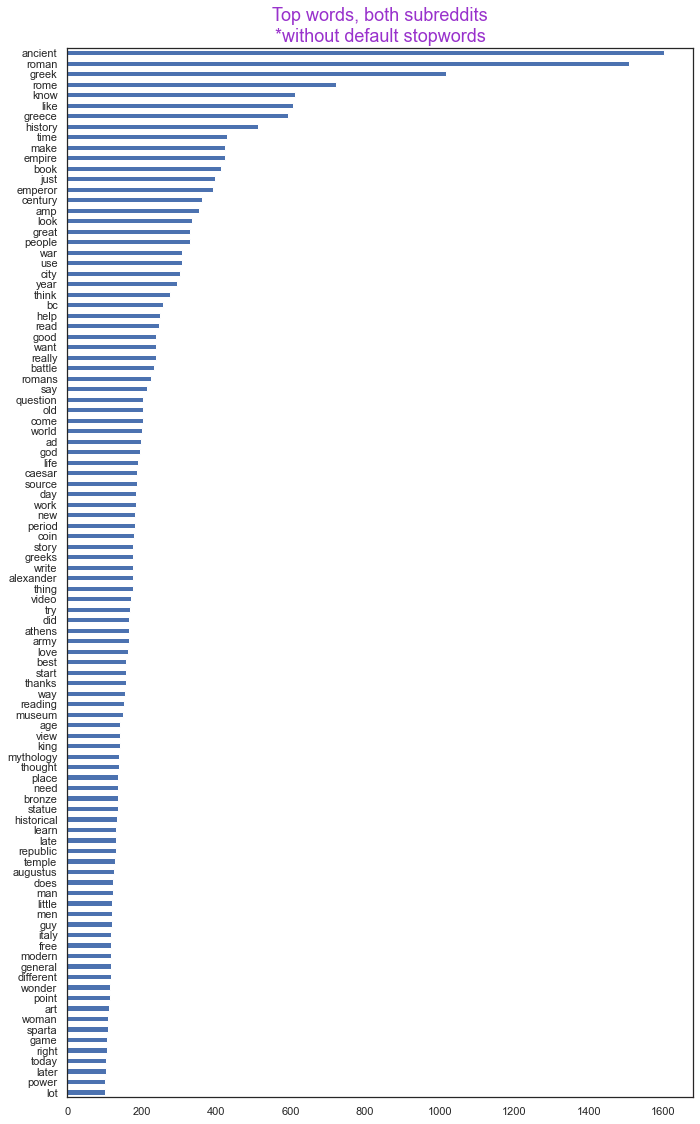

In [46]:
# vectorize the post column and turn into a dataframe
X = reddit2['posts']
X_vec = cvec.fit_transform(X)
X_df = pd.DataFrame(X_vec.todense(), 
                          columns=cvec.get_feature_names())

# plot top occuring words
fig, ax = plt.subplots(figsize = (10,18))
X_df.sum().sort_values(ascending=True)[-100:].plot(kind = 'barh')
plt.yticks(fontsize=11)
plt.title("Top words, both subreddits\n*without default stopwords"
         , color='darkorchid', fontsize=18)
plt.show()

- the next cell's coding simplicity belies its importance in this project. expending the list of stop-words is crucial to make the model a true 'machine-learning' model rather than a 'word-searching' one.
- error can be made on both sides - by discarding too many as well as too few. The former leaves too tough a task for the machine to learn to distinguish between two very similar periods of classical history, while the latter turns it into a 'word-search' problem, as just mentioned
- another dimension to this problem is that many words will be discarded later on during vectorization with parameters such as 'max_features' and 'min_df'
- due to that reason, we will start cautiously by removing only the most blatantly biased words such as rome, greece, etc.

In [47]:
# updated list of my_stopwords
my_stopwords = ['ancient', 'roman', 'rome', 'romans', 'greek', 'greece',
                'greeks', 'amp' ] # obvious words + 'amp'

stopwords = update_stopwords(my_stopwords)
len(stopwords)

326

### Analyze words by each subreddit separately 

In [48]:
X_greek = reddit2[reddit2['subreddit']=='ancientgreece']['posts']
X_roman = reddit2[reddit2['subreddit']=='ancientrome']['posts']
X_greek.shape
X_roman.shape

(2839,)

In [49]:
# vectorize both, to do a detailed analysis of top words in each subreddit
X_greek_vec = cvec.fit_transform(X_greek)
X_greek_df = pd.DataFrame(X_greek_vec.todense(), 
                          columns=cvec.get_feature_names())
X_roman_vec = cvec.fit_transform(X_roman)
X_roman_df = pd.DataFrame(X_roman_vec.todense(), 
                          columns=cvec.get_feature_names())

In [50]:
# check our overlap function for 1000 most popular words in each subreddit
print(overlap(X_greek_df, X_roman_df,1000)[1])

0.62


0.62 means that 620 out of the 1000 most common words from each subreddit are the same

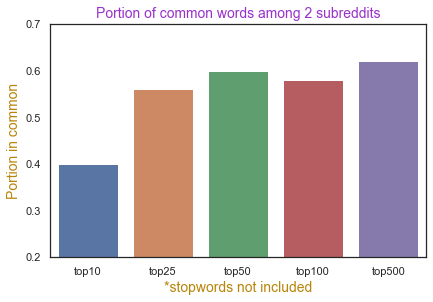

In [51]:

lst = [10, 25, 50, 100, 500] # list for top10 to top500

#create a list of common words among top i words in each subredding using the function overlap 
#from the top of the notebook
common_words = {f'top{i}': overlap(X_greek_df, X_roman_df, i)[1] for i in lst}

sns.barplot(x=list(common_words.keys()), y=list(common_words.values()))   
plt.ylim(0.2,0.7)
plt.title('Portion of common words among 2 subreddits', fontsize=14, color='darkorchid')
plt.ylabel('Portion in common', fontsize=14, color='darkgoldenrod')
plt.xlabel('*stopwords not included', fontsize=14, color='darkgoldenrod')
plt.show()

- the percentage of common, highly-occurring words is quite high between the greek and the roman subreddits, between 50% and 60%, depending on how many most frequent words are used for comparison. 
- we will need to develop a sharp model to be able to distinguish among the subreddits, which is not unexpected, since the topics are quite similar.
- next check which words are among the most frequent in both

In [52]:
# common words among top 10
print('Common words among the top 10 most frequent in each subreddit are ',overlap(X_greek_df, X_roman_df,10)[0])
print('Common words among the next 15 in the top 25 are ',overlap(X_greek_df, X_roman_df,25)[0] -
      overlap(X_greek_df, X_roman_df,10)[0])

Common words among the top 10 most frequent in each subreddit are  {'history', 'like', 'know', 'ancient'}
Common words among the next 15 in the top 25 are  {'look', 'just', 'war', 'use', 'book', 'century', 'great', 'make', 'time', 'people'}


- we will add some of this words (such as 'like', 'make' etc) to the list of stopwords, while other like 'war' we will keep as they might acquire more meaning as a bigram (eg Punic War, Peloponnesian War, City States etc)

In [53]:
# updated list of my_stopwords
my_stopwords = ['ancient', 'roman', 'rome', 'romans', 'greek', 'greece',
                'greeks', 'amp','know', 'like', 'make', 'look', 'just', 'use'] 

stopwords = update_stopwords(my_stopwords)
len(stopwords)

332

### Check the final top 25 words

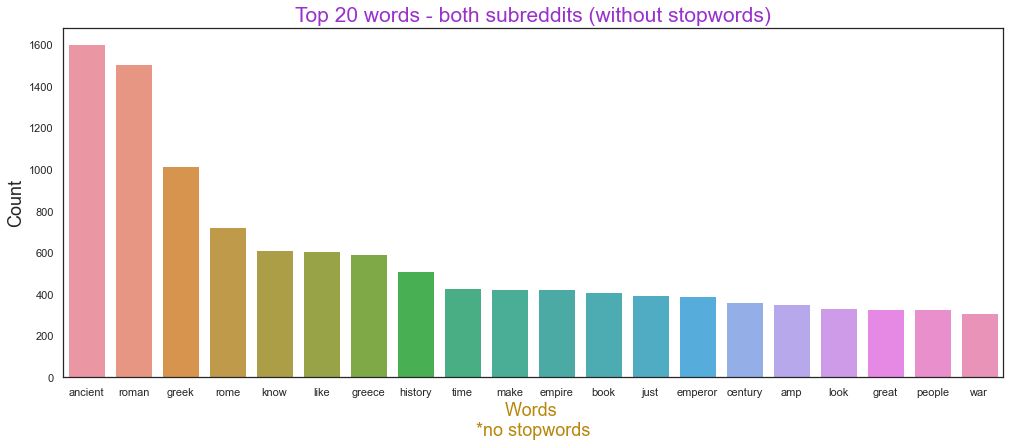

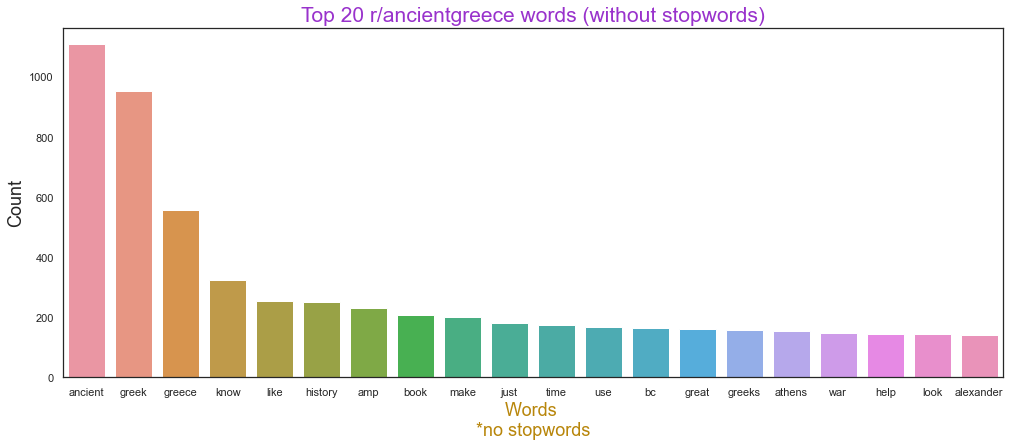

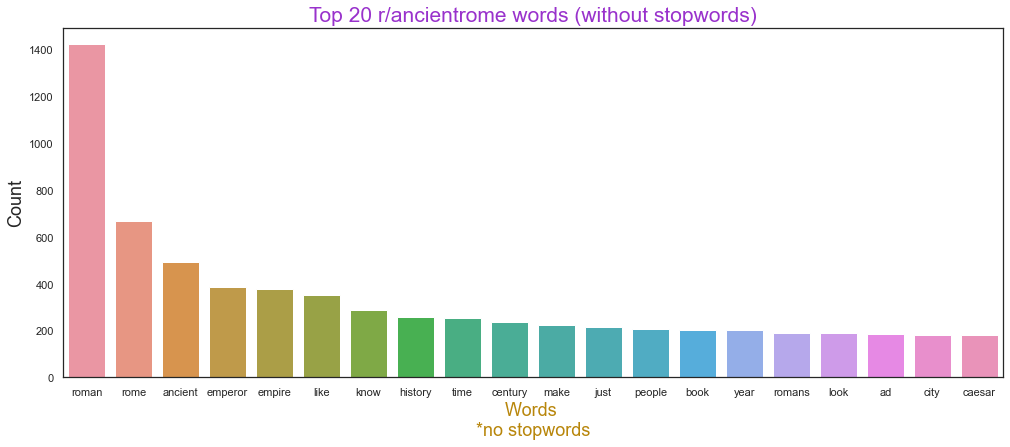

In [54]:
xrome = X_roman_df.sum().sort_values(ascending=False).head(20).rename('Count')
xgreece = X_greek_df.sum().sort_values(ascending=False).head(20).rename('Count')
xboth = X_df.sum().sort_values(ascending=False).head(20).rename('Count')
plt_bar(xboth, 'Top 20 words - both subreddits')
plt_bar(xgreece, 'Top 20 r/ancientgreece words')
plt_bar(xrome, 'Top 20 r/ancientrome words')

- upon closer inspection, only the word 'really' should be further added to the stopword list . some words don't seem useful now but might be useful later as a part of an n-gram, while others seem downright useful
- we are especially encouraged by the tiny words of 'bc' and 'ad' on the list. Originally the word 'ad' caught our eye as yet another potential intrusion of the omni-present advertisement industry which engulfs the entire internet these days, but here it stands for 'anno domini' and, together with 'bc', looks encouraging as 'ad' appears in roman reddit while 'bc' in the greek one. That makes sense since the majority of ancient greek history took place in bc (before christ), while the big events of the roman civilization unfolded in 'ad'

In [55]:
my_stopwords.append('really')
stopwords = update_stopwords(my_stopwords)
len(stopwords)


333

### Update stopwords

In [56]:
# check the start and end of our word list (X_df.columns) since they are the most likely to include non-standard words
# only check those words that appear at least twice, since we will have df_min of at least 2 when we run our models. 
# (if we included the words that appear only once, the list would be uncomfortably long)

lst = [col for col in X_df.columns if (X_df[col].sum()>=2)] # list comprehension for all the words with 2+ appearances
 # since we'll be using min_df=2 or more, there's no need wasting time removing words that appear just once
print(f'There are {len(lst)} words that appear at least twice. The first 10 and the last 100 are: \n')
print(lst[:10], '\n', lst[-100:])

There are 7175 words that appear at least twice. The first 10 and the last 100 are: 

['ab', 'abandon', 'abandoned', 'abdalonymus', 'abdashtart', 'abdera', 'abdicate', 'abduct', 'ability', 'able'] 
 ['zeugma', 'zeus', 'zoroastrianism', 'zosimus', 'ádám', 'ένα', 'αν', 'από', 'αρχαία', 'αἰδοῖον', 'γε', 'για', 'δεν', 'είναι', 'ζωή', 'θα', 'και', 'καὶ', 'κύβος', 'λοιμοῦ', 'με', 'μου', 'νέο', 'να', 'νεφέλην', 'οι', 'που', 'σε', 'στο', 'στον', 'τα', 'τη', 'την', 'της', 'τι', 'το', 'τον', 'του', 'τους', 'των', 'τῇ', 'τῶν', 'φωτογραφίες', 'χαίρετε', 'χωρίς', 'аnd', 'оf', 'раssed', 'עברתי', 'ἀθήναζε', 'ἀνερρίφθω', '𝗔𝘄𝗮𝗿𝗱', '𝗕𝗲𝗹𝗳𝗮𝘀𝘁', '𝗗𝗼𝗰', '𝗗𝘂𝗯𝗹𝗶𝗻', '𝗙𝗲𝘀𝘁𝗶𝘃𝗮𝗹', '𝗙𝗶𝗹𝗺', '𝗚𝗿𝗲𝗲𝗸', '𝗜𝗻𝗱𝗶𝗲𝗖𝗼𝗿𝗸', '𝗜𝗻𝘁𝗲𝗿𝗻𝗮𝘁𝗶𝗼𝗻𝗮𝗹', '𝗢𝗙𝗙𝗜𝗖𝗜𝗔𝗟', '𝗥𝗼𝘁𝘁𝗲𝗿𝗱𝗮𝗺', '𝗦𝗘𝗟𝗘𝗖𝗧𝗜𝗢𝗡', '𝗦𝗽𝗶𝗿𝗶𝘁', '𝗧𝗵𝗲𝘀𝘀𝗮𝗹𝗼𝗻𝗶𝗸𝗶', '𝗪𝗜𝗡𝗡𝗘𝗥', '𝗼𝗳', '𝘁𝗵𝗲', '𝘋𝘪𝘳𝘦𝘤𝘵𝘰𝘳', '𝘋𝘰𝘺𝘭𝘦', '𝘋𝘶𝘣𝘭𝘪𝘯', '𝘎𝘳á𝘪𝘯𝘯𝘦', '𝘏𝘶𝘮𝘱𝘩𝘳𝘦𝘺𝘴', '𝘐𝘍𝘍', '𝘙𝘰𝘯𝘢𝘯', '𝘚𝘤𝘢𝘯𝘯𝘢𝘪𝘯', '𝘽𝙐𝙍𝙉𝙄𝙉𝙂', '𝙎𝙏𝙍𝙀𝘼𝙈𝙎', '𝙖𝙣𝙙', '𝙖𝙧𝙚', '𝙙𝙚𝙨𝙘𝙧𝙞𝙗𝙚', '𝙙𝙞𝙛𝙛𝙞𝙘𝙪𝙡𝙩', '𝙙𝙧𝙖𝙬𝙣', '𝙚𝙢𝙗𝙧𝙖𝙘𝙚', '𝙝𝙖𝙧𝙙', '𝙝𝙖𝙧𝙙𝙚𝙧', '𝙞𝙛', '𝙠𝙣𝙚𝙬', '𝙤𝙗𝙨𝙘𝙪𝙧𝙚

- many words escaped lemmatization and cleaning as they are written in non-standard characters. investigate.

- we have a motley crew of words after our last word on a-z alphabet (zosimus). ancient greek words are obvious, but there are some other words that appear regular, yet they didn't get sorted so they are obviously not.
- check them out

In [57]:
('оf' == 'of') or ('Award' == '𝗔𝘄𝗮𝗿𝗱')

False

In [58]:
# investigate further
# sample char from the list
lst[-20][-1] 

'𝙚'

In [59]:
# its unicode
ord(lst[-1][-1])

120409

In [60]:
#another one
ord('𝘎')

120334

In [61]:
#unicode of a regular char
ord('G')

71

- there are a many words that appear at the end that are written in what look like words, but are actually more like symbols, using fonts such as "Mathematical Sans-Serif", both bold and italic. they are spam, which escaped our cleaning function since, while technically alphanumeric, is so far up the Unicode that our function didn't really recognize it.
- since they are more like symbols, there is no easy (or any?) way to convert them to regular chars. the easiest way to proceed is to copy and paste them into our stopwords

In [62]:
print('if' in stopwords)
print('𝙞𝙛' in stopwords)

True
False


In [63]:
# as our df_min will be at least two, these words will be added to our stopword list
# this iteration contain no greeks written in ancient greek

temp_list = ['𝗔𝘄𝗮𝗿𝗱', '𝗕𝗲𝗹𝗳𝗮𝘀𝘁', '𝗗𝗼𝗰', '𝗗𝘂𝗯𝗹𝗶𝗻', '𝗙𝗲𝘀𝘁𝗶𝘃𝗮𝗹',
 '𝗙𝗶𝗹𝗺', '𝗚𝗿𝗲𝗲𝗸', '𝗜𝗻𝗱𝗶𝗲𝗖𝗼𝗿𝗸', '𝗜𝗻𝘁𝗲𝗿𝗻𝗮𝘁𝗶𝗼𝗻𝗮𝗹', '𝗢𝗙𝗙𝗜𝗖𝗜𝗔𝗟', '𝗥𝗼𝘁𝘁𝗲𝗿𝗱𝗮𝗺',
 '𝗦𝗘𝗟𝗘𝗖𝗧𝗜𝗢𝗡', '𝗦𝗽𝗶𝗿𝗶𝘁', '𝗧𝗵𝗲𝘀𝘀𝗮𝗹𝗼𝗻𝗶𝗸𝗶', '𝗪𝗜𝗡𝗡𝗘𝗥', '𝗼𝗳', '𝘁𝗵𝗲', '𝘋𝘪𝘳𝘦𝘤𝘵𝘰𝘳',
 '𝘋𝘰𝘺𝘭𝘦', '𝘋𝘶𝘣𝘭𝘪𝘯', '𝘎𝘳á𝘪𝘯𝘯𝘦', '𝘏𝘶𝘮𝘱𝘩𝘳𝘦𝘺𝘴', '𝘐𝘍𝘍', '𝘙𝘰𝘯𝘢𝘯', '𝘚𝘤𝘢𝘯𝘯𝘢𝘪𝘯',
 '𝘽𝙐𝙍𝙉𝙄𝙉𝙂', '𝙎𝙏𝙍𝙀𝘼𝙈𝙎', '𝙖𝙣𝙙', '𝙖𝙧𝙚', '𝙙𝙚𝙨𝙘𝙧𝙞𝙗𝙚', '𝙙𝙞𝙛𝙛𝙞𝙘𝙪𝙡𝙩', '𝙙𝙧𝙖𝙬𝙣',
 '𝙚𝙢𝙗𝙧𝙖𝙘𝙚', '𝙝𝙖𝙧𝙙', '𝙝𝙖𝙧𝙙𝙚𝙧', '𝙞𝙛', '𝙠𝙣𝙚𝙬', '𝙤𝙗𝙨𝙘𝙪𝙧𝙚', '𝙤𝙣𝙚𝙨', '𝙤𝙣𝙡𝙮',
 '𝙦𝙪𝙖𝙣𝙩𝙞𝙛𝙮', '𝙨𝙖𝙬', '𝙨𝙪𝙗𝙟𝙚𝙘𝙩𝙨', '𝙩𝙝𝙖𝙩', '𝙩𝙝𝙚', '𝙩𝙝𝙚𝙮', '𝙩𝙤', '𝙬𝙤𝙧𝙡𝙙', '𝙬𝙤𝙪𝙡𝙙']

In [64]:
# ...and this one includes ancient greek words

temp_list_greek =  ['ádám', 'ένα', 'αν', 'από', 'αρχαία', 'αἰδοῖον', 'γε', 'για', 'δεν', 'είναι', 'ζωή', 'θα', 'και', 'καὶ',
               'κύβος', 'λοιμοῦ', 'με', 'μου', 'νέο', 'να', 'νεφέλην', 'οι', 'που', 'σε', 'στο', 'στον', 'τα', 'τη',
               'την', 'της', 'τι', 'το', 'τον', 'του', 'τους', 'των', 'τῇ', 'τῶν', 'φωτογραφίες', 'χαίρετε', 'χωρίς',
               'аnd', 'оf', 'раssed', 'עברתי', 'ἀθήναζε', 'ἀνερρίφθω', '𝗔𝘄𝗮𝗿𝗱', '𝗕𝗲𝗹𝗳𝗮𝘀𝘁', '𝗗𝗼𝗰', '𝗗𝘂𝗯𝗹𝗶𝗻', '𝗙𝗲𝘀𝘁𝗶𝘃𝗮𝗹',
               '𝗙𝗶𝗹𝗺', '𝗚𝗿𝗲𝗲𝗸', '𝗜𝗻𝗱𝗶𝗲𝗖𝗼𝗿𝗸', '𝗜𝗻𝘁𝗲𝗿𝗻𝗮𝘁𝗶𝗼𝗻𝗮𝗹', '𝗢𝗙𝗙𝗜𝗖𝗜𝗔𝗟', '𝗥𝗼𝘁𝘁𝗲𝗿𝗱𝗮𝗺', '𝗦𝗘𝗟𝗘𝗖𝗧𝗜𝗢𝗡', '𝗦𝗽𝗶𝗿𝗶𝘁', '𝗧𝗵𝗲𝘀𝘀𝗮𝗹𝗼𝗻𝗶𝗸𝗶',
               '𝗪𝗜𝗡𝗡𝗘𝗥', '𝗼𝗳', '𝘁𝗵𝗲', '𝘋𝘪𝘳𝘦𝘤𝘵𝘰𝘳', '𝘋𝘰𝘺𝘭𝘦', '𝘋𝘶𝘣𝘭𝘪𝘯', '𝘎𝘳á𝘪𝘯𝘯𝘦', '𝘏𝘶𝘮𝘱𝘩𝘳𝘦𝘺𝘴', '𝘐𝘍𝘍', '𝘙𝘰𝘯𝘢𝘯', '𝘚𝘤𝘢𝘯𝘯𝘢𝘪𝘯',
               '𝘽𝙐𝙍𝙉𝙄𝙉𝙂', '𝙎𝙏𝙍𝙀𝘼𝙈𝙎', '𝙖𝙣𝙙', '𝙖𝙧𝙚', '𝙙𝙚𝙨𝙘𝙧𝙞𝙗𝙚', '𝙙𝙞𝙛𝙛𝙞𝙘𝙪𝙡𝙩', '𝙙𝙧𝙖𝙬𝙣', '𝙚𝙢𝙗𝙧𝙖𝙘𝙚', '𝙝𝙖𝙧𝙙', '𝙝𝙖𝙧𝙙𝙚𝙧',
               '𝙞𝙛', '𝙠𝙣𝙚𝙬', '𝙤𝙗𝙨𝙘𝙪𝙧𝙚', '𝙤𝙣𝙚𝙨', '𝙤𝙣𝙡𝙮', '𝙦𝙪𝙖𝙣𝙩𝙞𝙛𝙮', '𝙨𝙖𝙬', '𝙨𝙪𝙗𝙟𝙚𝙘𝙩𝙨', '𝙩𝙝𝙖𝙩', '𝙩𝙝𝙚', '𝙩𝙝𝙚𝙮', '𝙩𝙤',
               '𝙬𝙤𝙧𝙡𝙙', '𝙬𝙤𝙪𝙡𝙙']

In [65]:
len(my_stopwords)

15

In [66]:
len(temp_list)

49

In [67]:
len(temp_list_greek)

96

In [68]:
# add non-greek words to stopwords
# use list.extend this time to get individual elements
my_stopwords.extend(temp_list)
len(my_stopwords)

64

In [69]:
# print and copy&paste non-greek stopwords, for modeling in the next notebook
print("non greek:\n\n",my_stopwords)

non greek:

 ['ancient', 'roman', 'rome', 'romans', 'greek', 'greece', 'greeks', 'amp', 'know', 'like', 'make', 'look', 'just', 'use', 'really', '𝗔𝘄𝗮𝗿𝗱', '𝗕𝗲𝗹𝗳𝗮𝘀𝘁', '𝗗𝗼𝗰', '𝗗𝘂𝗯𝗹𝗶𝗻', '𝗙𝗲𝘀𝘁𝗶𝘃𝗮𝗹', '𝗙𝗶𝗹𝗺', '𝗚𝗿𝗲𝗲𝗸', '𝗜𝗻𝗱𝗶𝗲𝗖𝗼𝗿𝗸', '𝗜𝗻𝘁𝗲𝗿𝗻𝗮𝘁𝗶𝗼𝗻𝗮𝗹', '𝗢𝗙𝗙𝗜𝗖𝗜𝗔𝗟', '𝗥𝗼𝘁𝘁𝗲𝗿𝗱𝗮𝗺', '𝗦𝗘𝗟𝗘𝗖𝗧𝗜𝗢𝗡', '𝗦𝗽𝗶𝗿𝗶𝘁', '𝗧𝗵𝗲𝘀𝘀𝗮𝗹𝗼𝗻𝗶𝗸𝗶', '𝗪𝗜𝗡𝗡𝗘𝗥', '𝗼𝗳', '𝘁𝗵𝗲', '𝘋𝘪𝘳𝘦𝘤𝘵𝘰𝘳', '𝘋𝘰𝘺𝘭𝘦', '𝘋𝘶𝘣𝘭𝘪𝘯', '𝘎𝘳á𝘪𝘯𝘯𝘦', '𝘏𝘶𝘮𝘱𝘩𝘳𝘦𝘺𝘴', '𝘐𝘍𝘍', '𝘙𝘰𝘯𝘢𝘯', '𝘚𝘤𝘢𝘯𝘯𝘢𝘪𝘯', '𝘽𝙐𝙍𝙉𝙄𝙉𝙂', '𝙎𝙏𝙍𝙀𝘼𝙈𝙎', '𝙖𝙣𝙙', '𝙖𝙧𝙚', '𝙙𝙚𝙨𝙘𝙧𝙞𝙗𝙚', '𝙙𝙞𝙛𝙛𝙞𝙘𝙪𝙡𝙩', '𝙙𝙧𝙖𝙬𝙣', '𝙚𝙢𝙗𝙧𝙖𝙘𝙚', '𝙝𝙖𝙧𝙙', '𝙝𝙖𝙧𝙙𝙚𝙧', '𝙞𝙛', '𝙠𝙣𝙚𝙬', '𝙤𝙗𝙨𝙘𝙪𝙧𝙚', '𝙤𝙣𝙚𝙨', '𝙤𝙣𝙡𝙮', '𝙦𝙪𝙖𝙣𝙩𝙞𝙛𝙮', '𝙨𝙖𝙬', '𝙨𝙪𝙗𝙟𝙚𝙘𝙩𝙨', '𝙩𝙝𝙖𝙩', '𝙩𝙝𝙚', '𝙩𝙝𝙚𝙮', '𝙩𝙤', '𝙬𝙤𝙧𝙡𝙙', '𝙬𝙤𝙪𝙡𝙙']


In [70]:
# create another list, with greep alphabet words. first we should remove the recently added temp_list, so 
# there are no duplicates
for item in temp_list:
    my_stopwords.remove(item)
my_stopwords.extend(temp_list_greek)    
len(my_stopwords) # to check of it's 15+96

111

In [71]:
# print and copy&paste all stopwords, for modeling in the next notebook
print("greek:\n\n",my_stopwords)

greek:

 ['ancient', 'roman', 'rome', 'romans', 'greek', 'greece', 'greeks', 'amp', 'know', 'like', 'make', 'look', 'just', 'use', 'really', 'ádám', 'ένα', 'αν', 'από', 'αρχαία', 'αἰδοῖον', 'γε', 'για', 'δεν', 'είναι', 'ζωή', 'θα', 'και', 'καὶ', 'κύβος', 'λοιμοῦ', 'με', 'μου', 'νέο', 'να', 'νεφέλην', 'οι', 'που', 'σε', 'στο', 'στον', 'τα', 'τη', 'την', 'της', 'τι', 'το', 'τον', 'του', 'τους', 'των', 'τῇ', 'τῶν', 'φωτογραφίες', 'χαίρετε', 'χωρίς', 'аnd', 'оf', 'раssed', 'עברתי', 'ἀθήναζε', 'ἀνερρίφθω', '𝗔𝘄𝗮𝗿𝗱', '𝗕𝗲𝗹𝗳𝗮𝘀𝘁', '𝗗𝗼𝗰', '𝗗𝘂𝗯𝗹𝗶𝗻', '𝗙𝗲𝘀𝘁𝗶𝘃𝗮𝗹', '𝗙𝗶𝗹𝗺', '𝗚𝗿𝗲𝗲𝗸', '𝗜𝗻𝗱𝗶𝗲𝗖𝗼𝗿𝗸', '𝗜𝗻𝘁𝗲𝗿𝗻𝗮𝘁𝗶𝗼𝗻𝗮𝗹', '𝗢𝗙𝗙𝗜𝗖𝗜𝗔𝗟', '𝗥𝗼𝘁𝘁𝗲𝗿𝗱𝗮𝗺', '𝗦𝗘𝗟𝗘𝗖𝗧𝗜𝗢𝗡', '𝗦𝗽𝗶𝗿𝗶𝘁', '𝗧𝗵𝗲𝘀𝘀𝗮𝗹𝗼𝗻𝗶𝗸𝗶', '𝗪𝗜𝗡𝗡𝗘𝗥', '𝗼𝗳', '𝘁𝗵𝗲', '𝘋𝘪𝘳𝘦𝘤𝘵𝘰𝘳', '𝘋𝘰𝘺𝘭𝘦', '𝘋𝘶𝘣𝘭𝘪𝘯', '𝘎𝘳á𝘪𝘯𝘯𝘦', '𝘏𝘶𝘮𝘱𝘩𝘳𝘦𝘺𝘴', '𝘐𝘍𝘍', '𝘙𝘰𝘯𝘢𝘯', '𝘚𝘤𝘢𝘯𝘯𝘢𝘪𝘯', '𝘽𝙐𝙍𝙉𝙄𝙉𝙂', '𝙎𝙏𝙍𝙀𝘼𝙈𝙎', '𝙖𝙣𝙙', '𝙖𝙧𝙚', '𝙙𝙚𝙨𝙘𝙧𝙞𝙗𝙚', '𝙙𝙞𝙛𝙛𝙞𝙘𝙪𝙡𝙩', '𝙙𝙧𝙖𝙬𝙣', '𝙚𝙢𝙗𝙧𝙖𝙘𝙚', '𝙝𝙖𝙧𝙙', '𝙝𝙖𝙧𝙙𝙚𝙧', '𝙞𝙛', '𝙠𝙣𝙚𝙬', '𝙤𝙗𝙨𝙘𝙪𝙧𝙚', '𝙤𝙣𝙚𝙨', '𝙤𝙣𝙡𝙮', '𝙦𝙪𝙖𝙣𝙩𝙞𝙛𝙮', '𝙨𝙖𝙬', '𝙨𝙪𝙗𝙟𝙚𝙘𝙩𝙨', '𝙩𝙝𝙖𝙩', '𝙩𝙝𝙚', '𝙩𝙝𝙚𝙮', '𝙩𝙤', '𝙬𝙤𝙧𝙡𝙙', '𝙬𝙤𝙪𝙡𝙙']


In [72]:
reddit2[reddit2['posts'].duplicated(keep=False)].head(100)

,created_utc,title,selftext,subreddit,posts
129,1638460297,"Greek funerary helmet, 560-550 BC, Archaeologi...",,ancientgreece,greek funerary helmet bc archaeological museum...
144,1638178725,"Greek funerary helmet, 560-550 BC, Archaeologi...",,ancientgreece,greek funerary helmet bc archaeological museum...
230,1635925127,#THE_SEPTERNITY_OF_LIBERAL_ARTS,,ancientgreece,
245,1635661918,#THE_QUINTERNITY_OF_CLASSICAL_ELEMENTS,,ancientgreece,
439,1630741734,"Massalia 300 BC A map from a new ""nation/RP/st...",,ancientgreece,massalia bc a map from a new discord game lore...
...,...,...,...,...,...
5598,1624091503,Nude Server Invite 💜🤍🥰,,ancientrome,nude server invite
5629,1623878717,https://www.artichaeology.com/paintings-depict...,[https://www.artichaeology.com/paintings-depic...,ancientrome,
5638,1623836471,/r/ancientrome hit 80k subscribers yesterday,,ancientrome,hit subscriber yesterday
5794,1622748264,Roman Emperors Portrayed in Memes - Part 2,,ancientrome,roman emperors portrayed in memes part


## Final cleanup and save

In [73]:
# last check before running models
reddit2.isnull().sum()

created_utc    0
title          0
selftext       0
subreddit      0
posts          0
dtype: int64

In [74]:
# while there might not be nan values, there might be empty strings due to the 
# nature of our cleanup function
reddit2.loc[reddit2['posts']=='']

,created_utc,title,selftext,subreddit,posts
230,1635925127,#THE_SEPTERNITY_OF_LIBERAL_ARTS,,ancientgreece,
245,1635661918,#THE_QUINTERNITY_OF_CLASSICAL_ELEMENTS,,ancientgreece,
974,1619009251,⚜️⚜️⚜️⚜️⚜️,,ancientgreece,
1987,1588248413,https://youtu.be/7izujEa5QLA,,ancientgreece,
2166,1580341334,...,,ancientgreece,
2310,1569498285,being-spartan-the-practice-behind-the-legend-i...,,ancientgreece,
2325,1568890215,being-spartan-the-practice-behind-the-legend-g...,,ancientgreece,
2450,1558805865,R.I.P,,ancientgreece,
4240,1633668330,MEGABET333 คาสิโนออนไลน์ เครดิตฟรี เงื่อนไขดีท...,,ancientrome,
4562,1631484442,MY-HISTORICAL-DISCOVERIES,,ancientrome,


In [75]:
# easy decision - drop them
reddit2.drop(reddit2.loc[reddit2['posts']==''].index, inplace=True)

In [76]:
reddit2['subreddit'].value_counts()

ancientrome      2832
ancientgreece    2743
Name: subreddit, dtype: int64

In [77]:
# dummify `subreddit` column
reddit2['subreddit'] = np.where(reddit2['subreddit']=='ancientrome', 0, 1)

- one last check - we had already removed all duplicates from the `post` column, but after having cleaned it, we might have created more duplicates. for example, the strings '555hercules is god' and 'hercules is god' (not a real example, just an illustration) would end up being duplicates after digits are removed by our customized cleaning function "cleanup"

In [78]:
#re-check for duplicates
reddit2['posts'].duplicated().sum()

36

In [79]:
# good we checked one more time. remove them
reddit2.drop_duplicates(subset=['posts'], inplace=True, ignore_index=True)

In [80]:
# save the file
reddit2.to_csv('../datasets/ancients_testing.csv', index=False)